<a href="https://colab.research.google.com/github/KittuPatel/CustomerPersonalityAnalysis/blob/main/CustomerPersonalityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Analyzing the domain of sales and understanding customer behavior.
*   Performing the Exploratory Data Analysis based on the insights gained from domain knowledge.
*   Pre-Processing of the data to remove the outliers, imputing the data for missing values.
*   Scaling the data to normalize the values.
*   Considering the important features by reducing the dimensionality using PCA.
*   Using the Clustering technique to identify the segments of customers.
*   Quantum Enhancements (Comparing Algorithm on Classical vs Quantum) 

In [77]:
# Import the pandas library. More information: https://pandas.pydata.org/
import pandas as pd
import numpy as np
# Importing the marketing campaign dataset
# Import the data as a pandas dataframe
cpa = pd.read_csv("/content/marketing_campaign.csv", sep="\t")

cpa.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Now let's learn more about the data and attributes of the given dataset. Given dataset can be divided into 4 parts:

Customer Information

Product Information

Promotion Information

Place Information

Dividing the attributes into their respective parts:

**Customer Information:**

-> ID : Customer's unique identification number

-> Year_Birth : Customer's birth year

-> Education : Customer's education status

-> Marital_Status : Customer's Marital status

-> Income : Customer's Income

-> Kidhome : Number of children in Customer's household

-> Teenhome : Number of teenagers in Customer's household

-> Dt_Customer : Customer's enrollment date with the company

-> Recency : Number of days since Customer's last purchase

-> Complain : 0 if Customer didn't complain in last 2 years, else 1

**Product Information:**

-> MntWines: Amount spent on wine in last 2 years

-> MntFruits: Amount spent on fruits in last 2 years

-> MntMeatProducts: Amount spent on meat products in last 2 years

-> MntFishProducts: Amount spent on fish products in last 2 years

-> MntSweetProducts: Amount spent on sweet products in last 2 years

-> MntGoldProds: Amount spent on gold products in last 2 years

**Promotion Information:**

-> NumDealsPurchases: Number of purchases made with a discount

-> AcceptedCmp1: 0 if Customer declined the offer in 1st campaign, else 1

-> AcceptedCmp2: 0 if Customer declined the offer in 2nd campaign, else 1

-> AcceptedCmp3: 0 if Customer declined the offer in 3rd campaign, else 1

-> AcceptedCmp4: 0 if Customer declined the offer in 4th campaign, else 1

-> AcceptedCmp5: 0 if Customer declined the offer in 5th campaign, else 1

-> Response: 0 if Customer declined the offer in the last campaign, else 1

**Place Information:**

-> NumWebPurchases: Number of purchases made through the company’s website

-> NumCatalogPurchases: Number of purchases made using a catalog

-> NumStorePurchases: Number of purchases made directly in store

-> NumWebVisitsMonth: Number of visits to company’s website in the last month

There are a total of 29 attributes and 2240 values

In [78]:
#overview of the attributes in the dataset
cpa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Only Income field has null values.

In [79]:
cpa['ID'].describe() #min value is zero, so all the data is positive. 

count     2240.000000
mean      5592.159821
std       3246.662198
min          0.000000
25%       2828.250000
50%       5458.500000
75%       8427.750000
max      11191.000000
Name: ID, dtype: float64

In [80]:
#replacing the income with mode.
mode = cpa['Income'].mode()[0]
cpa['Income'] = cpa['Income'].fillna(mode)
cpa['Income'].isna().sum() #checking the values

0

We will come across outliers, and we will remove them if they are less in number.

Now we are going to combine few columns into a single column

First getting into the family details :

-> Combine kidhome and teenhome to get the total number of children in the customer's household

-> Get the total headcount of the family

In [81]:
cpa['Kids'] = cpa['Kidhome'] + cpa['Teenhome']

#Deriving living situation by marital status Solo or Couple
cpa["Living_With"]=cpa["Marital_Status"].replace({"Married": 2, "Together": 2, "Absurd": 1, "Alone":1, "Widow": 1, "YOLO": 1, "Divorced": 1, "Single": 1,})

#Feature for total members in the householde
cpa["Family_headcount"] = cpa["Living_With"] + cpa['Kids']

#creating a feature pertaining parenthood
cpa["Is_Parent"] = np.where(cpa.Kids> 0, 1, 0)



**Lets** get the latest and oldest dates of customer's enrollement to get the span of this dataset

In [82]:
cpa['Dt_Customer'] = pd.to_datetime(cpa['Dt_Customer'])

cpa['Dt_Customer'].max(), cpa['Dt_Customer'].min()

(Timestamp('2014-12-06 00:00:00'), Timestamp('2012-01-08 00:00:00'))

The span is nearly 2 years.

Now lets go a little back in time so that we can get the details to be readable and makes much more sense.

We will assume that the customer information was collected 2014-12-07.

In [83]:
#calculating age based on Year of Birth
cpa['Age'] = 2014 - cpa['Year_Birth']

#Year_Birth is no longer required. So, dropping the column
cpa=cpa.drop(columns="Year_Birth")

#check the values in the new column
cpa['Age'].value_counts()

# data has outliers with age>100. setting the boundary as 100 replacing all values 100 where age is greater than 100
cpa['Age'].apply(lambda x: 100 if (x > 100) else x)


0       57
1       60
2       49
3       30
4       33
        ..
2235    47
2236    68
2237    33
2238    58
2239    60
Name: Age, Length: 2240, dtype: int64

In [84]:
cpa['Collected'] = '2014-12-07'
cpa['Collected'] = pd.to_datetime(cpa['Collected'])

cpa['Days_is_client'] = (cpa['Collected'] - cpa['Dt_Customer']).dt.days

Now going through the product and place details:

-> Get the total spending amount

-> Get the total number of purchases

-> Get Average Amount spent

-> Get the total share deals from the total number of purchases

-> Get the total number of accepted offers in all campaigns



In [85]:
cpa['MntTotal'] = cpa['MntWines']+cpa['MntFruits']+cpa['MntMeatProducts']+cpa['MntFishProducts']+cpa['MntSweetProducts']+cpa['MntGoldProds']

cpa['NumAllPurchases'] = cpa['NumWebPurchases']+cpa['NumCatalogPurchases']+cpa['NumStorePurchases']

cpa['AverageCheck'] = round((cpa['MntTotal'] / cpa['NumAllPurchases']), 1)

cpa['ShareDealsPurchases'] = round((cpa['NumDealsPurchases'] / cpa['NumAllPurchases']) * 100, 1)

cpa['TotalAcceptedCmp'] = cpa['AcceptedCmp1']+cpa['AcceptedCmp2']+cpa['AcceptedCmp3']+cpa['AcceptedCmp4']+cpa['AcceptedCmp5']+cpa['Response']

On checking the data we get to see that 6 customers have spent money but didn't make any purchase which makes no sense.

We are going to delete those six customers

Now our datacount will 2210

In [86]:
cpa = cpa.query("NumAllPurchases != 0")

Let's cover the outliers now

In [87]:
cpa['Income'] = np.where(cpa['Income'] > 120000, 120000, cpa['Income'])

cpa['AverageCheck'] = np.where(cpa['AverageCheck'] > 200, 200, cpa['AverageCheck'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
#Grouping education levels in to three categories
cpa["Education"]=cpa["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
#Deriving living situation by marital status Solo or Couple
cpa["Living_With"]=cpa["Marital_Status"].replace({"Married": 2, "Together": 2, "Absurd": 1, "Alone":1, "Widow": 1, "YOLO": 1, "Divorced": 1, "Single": 1,})

#Marital status is no longer required. So, dropping the column
cpa=cpa.drop(columns="Marital_Status")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
cpa

,ID,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Family_headcount,Is_Parent,Age,Collected,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp
0,5524,Graduate,58138.0,0,0,2012-04-09,58,635,88,546,...,1,0,57,2014-12-07,972,1617,22,73.5,13.6,1
1,2174,Graduate,46344.0,1,1,2014-08-03,38,11,1,6,...,3,1,60,2014-12-07,126,27,4,6.8,50.0,0
2,4141,Graduate,71613.0,0,0,2013-08-21,26,426,49,127,...,2,0,49,2014-12-07,473,776,20,38.8,5.0,0
3,6182,Graduate,26646.0,1,0,2014-10-02,26,11,4,20,...,3,1,30,2014-12-07,66,53,6,8.8,33.3,0
4,5324,Postgraduate,58293.0,1,0,2014-01-19,94,173,43,118,...,3,1,33,2014-12-07,322,422,14,30.1,35.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduate,61223.0,0,1,2013-06-13,46,709,43,182,...,3,1,47,2014-12-07,542,1341,16,83.8,12.5,0
2236,4001,Postgraduate,64014.0,2,1,2014-10-06,56,406,0,30,...,5,1,68,2014-12-07,62,444,15,29.6,46.7,1
2237,7270,Graduate,56981.0,0,0,2014-01-25,91,908,48,217,...,1,0,33,2014-12-07,316,1241,18,68.9,5.6,1
2238,8235,Postgraduate,69245.0,0,1,2014-01-24,8,428,30,214,...,3,1,58,2014-12-07,317,843,21,40.1,9.5,0


Let's cover the outliers now

In [91]:

#Segmenting education levels in to three groups
cpa["Education"]=cpa["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For better clarity
cpa=cpa.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Kidhome", "Teenhome", "Dt_Customer", "Z_CostContact", "Z_Revenue", "ID", "Collected"]

cpa = cpa.drop(to_drop, axis=1)

In [92]:
cpa.head()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Living_With,Family_headcount,Is_Parent,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp
0,Graduate,58138.0,58,635,88,546,172,88,88,3,...,1,1,0,57,972,1617,22,73.5,13.6,1
1,Graduate,46344.0,38,11,1,6,2,1,6,2,...,1,3,1,60,126,27,4,6.8,50.0,0
2,Graduate,71613.0,26,426,49,127,111,21,42,1,...,2,2,0,49,473,776,20,38.8,5.0,0
3,Graduate,26646.0,26,11,4,20,10,3,5,2,...,2,3,1,30,66,53,6,8.8,33.3,0
4,Postgraduate,58293.0,94,173,43,118,46,27,15,5,...,2,3,1,33,322,422,14,30.1,35.7,0


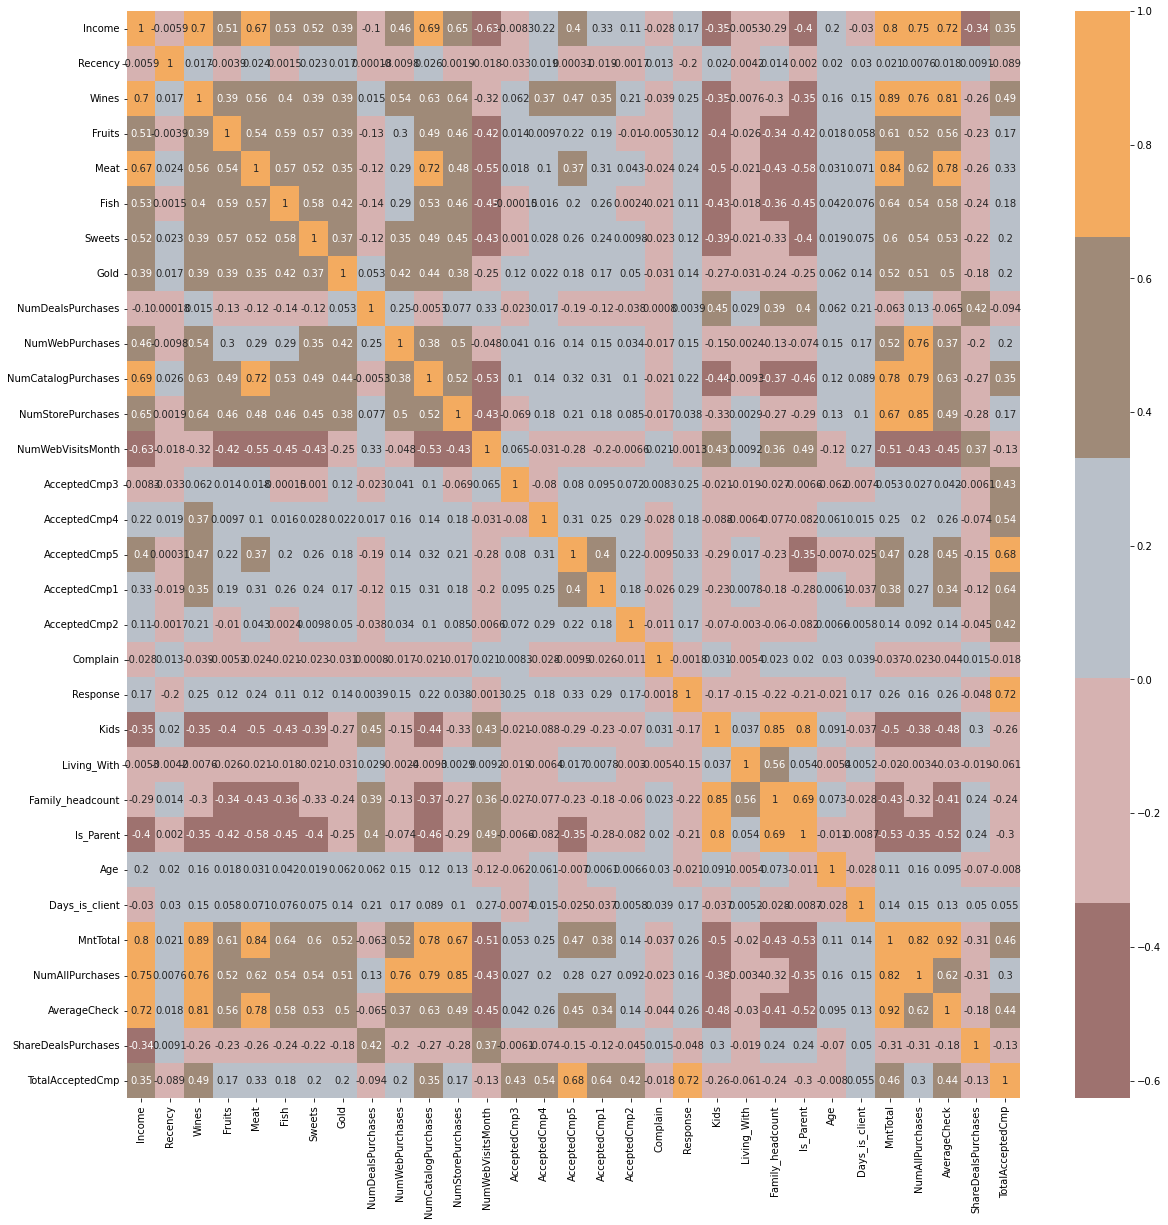

In [93]:
#Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib import colors
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
correlation_matrix= cpa.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(correlation_matrix,annot=True, cmap=cmap, center=0) #generating the matrix

We are going to preprocess the data to make the data available for PCA

Theese are the following steps will be applied to preprocess the data:

Ensure Label encoding will take place for the categorical features

Scale all the features using the standard scaler

Creating a copy of the subset dataframe for dimensionality reduction

In [94]:
#Listing the categorical variables
cpa_categorical = (cpa.dtypes == 'object')
object_cols = list(cpa_categorical[cpa_categorical].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education']


In [95]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    cpa[i]=cpa[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [96]:
cpa_copy = cpa.copy()
cat_col =  [x for x in cpa_copy.columns if ((cpa_copy[x].dtype != 'int64') & (cpa_copy[x].dtype != 'float64'))]
cpa_copy=pd.get_dummies(cpa_copy , columns=cat_col , drop_first=True)

In [97]:
from sklearn.preprocessing import StandardScaler
num_cols =  [x for x in cpa_copy.columns if ~((cpa_copy[x].dtype != 'int64') & (cpa_copy[x].dtype != 'float64'))]
Scaler = StandardScaler()
cpa_copy[num_cols] = Scaler.fit_transform(cpa_copy[num_cols])

Now we have encoded and normalized the data which is ready for dimensionality reduction.

In [97]:
to_drop=["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","NumDealsPurchases","NumWebVisitsMonth","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]
cpa = cpa.drop(to_drop, axis=1)